In [1]:
import sys
sys.path.append('../src')
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
import numpy as np
import tensorflow as tf
from gait.config import pd
from gait.utils import  get_overlap_data_all_sessions,  split_test_train_by_subjects, get_overlap_data_all_sessions
from gait.training import train_cnn_model_simple, build_cnn_stats_small_simple
from gait.evalution import save_history, save_test_history, save_accuracy_loss_figure, save_confusion_matrix_figure, compute_validations_predictions

In [2]:
model = build_cnn_stats_small_simple(128, 12, 5)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 12, 64)       3136      
                                                                 
 dropout (Dropout)           (None, 128, 12, 64)       0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 42, 4, 64)        0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 42, 4, 16)         12304     
                                                                 
 dropout_1 (Dropout)         (None, 42, 4, 16)         0         
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 14, 4, 16)        0         
 2D)                                                    

In [3]:
def compute_resultant_acceleration(X):
    return np.sqrt(X[:,:,0] **2 + X[:,:,1] ** 2 + X[:,:,2] ** 2)

def compute_resultant_gyro(X):
    return np.sqrt(X[:,:,3] **2 + X[:,:,4] ** 2 + X[:,:,5] ** 2)

def compute_resultant_angle(X):
    return np.sqrt(X[:,:,6] **2 + X[:,:,7] ** 2 + X[:,:,8] ** 2)

def get_std_values(X, channel):
    return np.std(X[:, :, channel], axis=1)

def get_mean_values(X, channel):
    return np.mean(X[:, :, channel], axis=1)

def get_max_values(X, channel):
    return np.max(X[:, :, channel], axis=1)

def get_median_values(X, channel):
    return np.median(X[:, :, channel], axis=1)


def get_statistic_feature_all_channels(X):
    statistic_features = []
    for channel in range(9,12):
        statistic_features.append(get_std_values(X, channel))
        statistic_features.append(get_mean_values(X, channel))
        statistic_features.append(get_max_values(X, channel))
        statistic_features.append(get_median_values(X, channel))

    return np.vstack(statistic_features).T

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 128, 12, 64)       3136      
                                                                 
 dropout_3 (Dropout)         (None, 128, 12, 64)       0         
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 42, 4, 64)        0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 42, 4, 16)         12304     
                                                                 
 dropout_4 (Dropout)         (None, 42, 4, 16)         0         
                                                                 
 max_pooling2d_3 (

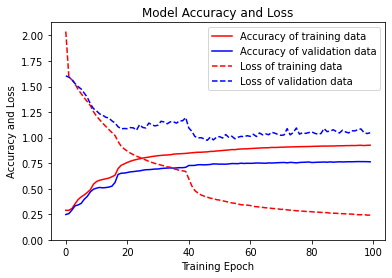

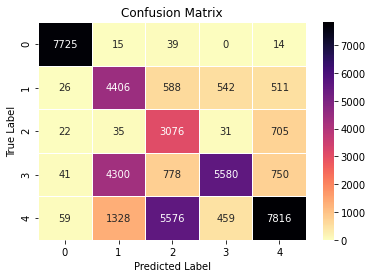

In [4]:
overlapPercents = [90]
# overlapPercents = [0]
# exclude_subjects = ['ddAeJA42PXvwthbW', 'nan', 'LLZjAPTyj7muHsEf',
#                     'MMuX9YIh4NTbLZLM', 'cbOZWnI7s1y8oLD4', 'PE8D53oX060qLbdX', 'xYdtS1F8tDyjEIgN', 'sUZBISq61Y7I5tqQ']
exclude_subjects = ['ddAeJA42PXvwthbW', 'nan',
                    'MMuX9YIh4NTbLZLM',
                    'NKdnm6cN3KKAx7R4',
                    'PE8D53oX060qLbdX',
                    'xYdtS1F8tDyjEIgN',
                    'EUbKPOSQgjccjtvi',
                    'PE8D53oX060qLbdX',
                    'ddAeJA42PXvwthbW',
                    'LLZjAPTyj7muHsEf',
                    'cbOZWnI7s1y8oLD4',
                    'ddAeJA42PXvwthbW',
                    '1ZstYhEKzKKfGnMW',
                    'LLZjAPTyj7muHsEf',
                    'bQsRwKxgJiXTzo6P',
                    'sUZBISq61Y7I5tqQ',
                    '19AoxD1bgrDckd2p',
                    'wtyNo4LYaWXrkzA7',
                    ]

for OVERLAP_PERCENT in overlapPercents:
    gpus = tf.config.list_logical_devices('GPU')
    strategy = tf.distribute.MirroredStrategy(gpus)
    with strategy.scope():
        X, y, subjects = get_overlap_data_all_sessions(OVERLAP_PERCENT)
        # REMOVE UNWANTED SUBJECTS
        indexes = np.where(subjects == exclude_subjects)
        X = np.delete(X, indexes[0], axis=0)
        y = np.delete(y, indexes[0], axis=0)
        subjects = np.delete(subjects, indexes[0], axis=0)
        # END REMOVE UNWANTED SUBJECTS

        # AUGMENT DATA
        resultant_acc = compute_resultant_acceleration(X)
        resultant_gyro = compute_resultant_gyro(X)
        resultant_angle = compute_resultant_angle(X)
        resultant_acc = resultant_acc.reshape(
            resultant_acc.shape[0], resultant_acc.shape[1], 1)
        resultant_gyro = resultant_gyro.reshape(
            resultant_gyro.shape[0], resultant_gyro.shape[1], 1)
        resultant_angle = resultant_angle.reshape(
            resultant_angle.shape[0], resultant_angle.shape[1], 1)
        X = np.concatenate((X, resultant_acc), axis=2)
        X = np.concatenate((X, resultant_gyro), axis=2)
        X = np.concatenate((X, resultant_angle), axis=2)
        # AUGMENT DATA END

        # print('UNIQUE subjects:', np.unique(subjects))
        X_train, X_test, y_train, y_test, y_train_non_encoded, y_test_non_encoded = split_test_train_by_subjects(
            X, y, subjects, train_percent=0.8)
        # X_train_stats = get_statistic_feature_all_channels(X_train)
        # X_test_stats = get_statistic_feature_all_channels(X_test)
        # print('Statistic feature shape: ', X_train_stats.shape)
        model, history = train_cnn_model_simple(
            X_train, y_train, X_test, overlap_percent=OVERLAP_PERCENT, batch_size=128, epochs=100)

        save_history(history, OVERLAP_PERCENT)
        evaluation_history = model.evaluate(
            X_test, y_test, batch_size=128, verbose=1)
        save_test_history(evaluation_history, OVERLAP_PERCENT)
        save_accuracy_loss_figure(history, OVERLAP_PERCENT)
        validations, predictions = compute_validations_predictions(
            model, X_test, y_test)
        save_confusion_matrix_figure(
            validations, predictions, OVERLAP_PERCENT, sns)


In [5]:
model.save('final_simple_cnn_with_5_labels')

INFO:tensorflow:Assets written to: final_simple_cnn_with_5_labels/assets


In [6]:
print(y_test.shape)

(44422, 5)


In [9]:
X_train_reshape = X_train.reshape(-1, X_train.shape[1], X_train.shape[2], 1).astype(np.float32)
print(X_train_reshape.shape)
X_test_reshape = X_test.reshape(-1, X_test.shape[1], X_test.shape[2], 1).astype(np.float32)
print(X_test_reshape.shape)

(103414, 128, 12, 1)
(44422, 128, 12, 1)


In [10]:
def representative_data_gen():
    for input_value in tf.data.Dataset.from_tensor_slices(X_test_reshape).batch(1).take(300):
        yield [input_value]


In [ ]:
keras_model = model
model.summary()

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_types = [tf.float16]
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_data_gen
tflite_quant_model = converter.convert()
open('float-quantized-model.tflite', 'wb').write(tflite_quant_model)

In [11]:
# Convert the model to the TensorFlow Lite format without quantization
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
# Enforce integer only quantization
converter.target_spec.supported_ops = [
    tf.lite.OpsSet.TFLITE_BUILTINS_INT8]

converter.inference_input_type = tf.int8
converter.inference_output_type = tf.int8
# Provide a representative dataset to ensure we quantize correctly.
converter.representative_dataset = representative_data_gen
model_tflite = converter.convert()

# Save the model to disk
open('int-quantized-model.tflite', 'wb').write(model_tflite)


INFO:tensorflow:Assets written to: /tmp/tmpqyx8z1k8/assets


/home/sanjeev/.local/lib/python3.9/site-packages/tensorflow/lite/python/convert.py:746: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn("Statistics for quantized inputs were expected, but not "


28432

In [ ]:
interpreter = tf.lite.Interpreter(model_path=str('int-quantized-model.tflite'))
interpreter.allocate_tensors()


In [ ]:
interpreter.get_input_details()

In [ ]:
X_train_reshape = X_train.reshape(-1, X_train.shape[1], X_train.shape[2], 1).astype(np.float32)
print(X_train_reshape.shape)
X_tensor = np.array([X_train_reshape[9000]]).astype(np.float32)
print(interpreter.get_input_details())

input_details = interpreter.get_input_details()
print('\n',interpreter.get_output_details(), '\n')
output_index = interpreter.get_output_details()[0]["index"]

interpreter.set_tensor(input_details[0]['index'], X_tensor)

interpreter.invoke()
predictions = interpreter.get_tensor(output_index)


In [ ]:
print(np.argmax(predictions[0]))
print(y_train[9000])

In [ ]:
def representative_data_gen():
    for input_value in tf.data.Dataset.from_tensor_slices(X_train_reshape).batch(1).take(100):
        yield [input_value]

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_data_gen
# Ensure that if any ops can't be quantized, the converter throws an error
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
# Set the input and output tensors to uint8 (APIs added in r2.3)
converter.inference_input_type = tf.uint8
converter.inference_output_type = tf.uint8

tflite_model_quant = converter.convert()
open('int-quantized-model.tflite', 'wb').write(tflite_quant_model)

## THIS DOES NOT WORK!!!

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
#converter.target_spec.supported_types = [tf.float32] this fails if you uncomment
converter.representative_dataset = representative_data_gen
tflite_model = converter.convert()

# Save the model to disk
open("model_quantized_2.tflite", "wb").write(tflite_model)

In [ ]:
interpreter = tf.lite.Interpreter(model_path=str('model_quantized_2.tflite'))
interpreter.allocate_tensors()


In [ ]:
interpreter.get_input_details()


In [ ]:
input_details = interpreter.get_input_details()
print('\n',input_details)
print('\n',interpreter.get_output_details(), '\n')

In [ ]:
OVERLAP_PERCENT = 0
# overlapPercents = [0]
# exclude_subjects = ['ddAeJA42PXvwthbW', 'nan', 'LLZjAPTyj7muHsEf',
#                     'MMuX9YIh4NTbLZLM', 'cbOZWnI7s1y8oLD4', 'PE8D53oX060qLbdX', 'xYdtS1F8tDyjEIgN', 'sUZBISq61Y7I5tqQ']
exclude_subjects = ['ddAeJA42PXvwthbW', 'nan',
                    'MMuX9YIh4NTbLZLM',
                    'NKdnm6cN3KKAx7R4',
                    'PE8D53oX060qLbdX',
                    'xYdtS1F8tDyjEIgN',
                    'EUbKPOSQgjccjtvi',
                    'PE8D53oX060qLbdX',
                    'ddAeJA42PXvwthbW',
                    'LLZjAPTyj7muHsEf',
                    'cbOZWnI7s1y8oLD4',
                    'ddAeJA42PXvwthbW',
                    '1ZstYhEKzKKfGnMW',
                    'LLZjAPTyj7muHsEf',
                    'bQsRwKxgJiXTzo6P',
                    'sUZBISq61Y7I5tqQ',
                    '19AoxD1bgrDckd2p',
                    'wtyNo4LYaWXrkzA7',
                    ]


X, y, subjects = get_overlap_data_all_sessions(OVERLAP_PERCENT)
# REMOVE UNWANTED SUBJECTS
indexes = np.where(subjects == exclude_subjects)
X = np.delete(X, indexes[0], axis=0)
y = np.delete(y, indexes[0], axis=0)
subjects = np.delete(subjects, indexes[0], axis=0)
# END REMOVE UNWANTED SUBJECT
# AUGMENT DATA
resultant_acc = compute_resultant_acceleration(X)
resultant_gyro = compute_resultant_gyro(X)
resultant_angle = compute_resultant_angle(X)
resultant_acc = resultant_acc.reshape(
    resultant_acc.shape[0], resultant_acc.shape[1], 1)
resultant_gyro = resultant_gyro.reshape(
    resultant_gyro.shape[0], resultant_gyro.shape[1], 1)
resultant_angle = resultant_angle.reshape(
    resultant_angle.shape[0], resultant_angle.shape[1], 1)
X = np.concatenate((X, resultant_acc), axis=2)
X = np.concatenate((X, resultant_gyro), axis=2)
X = np.concatenate((X, resultant_angle), axis=2)


In [ ]:
model.summary()

In [ ]:
print(X.shape)
print(y.shape)
X_train, X_test, y_train, y_test, y_train_non_encoded, y_test_non_encoded = split_test_train_by_subjects(
            X, y, subjects, train_percent=0.6)
evaluation_history = model.evaluate(
            X_test, y_test, batch_size=128, verbose=1)
save_test_history(evaluation_history, OVERLAP_PERCENT)
save_accuracy_loss_figure(history, OVERLAP_PERCENT)
validations, predictions = compute_validations_predictions(
    model, X_test, y_test)
save_confusion_matrix_figure(
    validations, predictions, OVERLAP_PERCENT, sns)

In [ ]:
model.save('good_model')